# Atmospheric composition distribution by CAMS and TROPOMI

### Main goal:
* Compare TROPOMI and CAMS datasets for NO<sub>2</sub>, CO, O<sub>3</sub> and SO<sub>2</sub> (Level 2).

## Imports and supporting functions

In [1]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import datetime as dt
import geocoder
import seaborn as sns
from matplotlib.cbook import boxplot_stats  
from matplotlib import animation
from IPython.display import HTML, display

In [2]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb

In [3]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [4]:
# Define component
component_nom = 'NO2'

# Define sensor
sensor = 'tropomi'
sensor_type = 'L2'

# Define model
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'

# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name, sensor_type)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom, sensor_type)

# Folders generation
generate_folders(model, sensor, component_nom, sensor_type)

The comparison is possible and will start now.


In [5]:
# Define extent
lon_min = 12
lon_max = 18.9
lat_min = 48.5
lat_max = 51.1

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define search period
start_date = '2021-10-01'
end_date = '2021-10-02'
dates = search_period(start_date, end_date, sensor, sensor_type)

SEARCH PERIOD
- In days: [('2021-10-01T00:00:00Z', '2021-10-01T23:00:00Z'), ('2021-10-02T00:00:00Z', '2021-10-02T23:00:00Z')]


## 2. Model data

### Download and read data as xarray

In [6]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, 
                                               component_nom, model_full_name, model_level = 'Multiple')

The file exists, it will not be downloaded again.


In [7]:
model_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_ds

<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 451, longitude: 900, step: 8, time: 2)
Coordinates:
  * time        (time) datetime64[ns] 2021-10-01 2021-10-02
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 -90.0 -89.6 -89.2 -88.8 ... 89.2 89.6 90.0
  * longitude   (longitude) float64 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-19T18:57 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [8]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/kg to molecules/cm<sup>2</sup>)

In [9]:
model_ds, units = model_convert_units(model_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg kg**-1 to kg m**-2.
The model component units have been converted from kg m**-2 to molec cm-2.


### Download read and subset original total columns data

In [10]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')
model_total_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_total_ds = subset(model_total_ds, bbox)
model_total_ds

The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:     (latitude: 8, longitude: 18, step: 8, time: 2)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-10-01 2021-10-02
  * step        (step) timedelta64[ns] 00:00:00 03:00:00 ... 18:00:00 21:00:00
    surface     float64 ...
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-10-19T18:57 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS total columns data units (kg/m2 to molecules/cm<sup>2</sup>)

In [11]:
model_total_ds, _ = model_convert_units(model_total_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg m**-2 to molec cm-2.


## 3. Sensor data

### Download and read data as xarray

In [12]:
# This won't work if the search period is older than one month
dates = sensor_download(sensor, sensor_type, component_nom, dates, bbox, product_type)

RESULTS
For ('2021-10-01T00:00:00Z', '2021-10-01T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-10-19 18:57:51,442 INFO Found 2 products


Number 0-S5P_NRTI_L2__NO2____20211001T122836_20211001T123336_20559_02_020200_20211001T132947
Number 1-S5P_NRTI_L2__NO2____20211001T104836_20211001T105336_20558_02_020200_20211001T125321
SELECTED
File name: b9af5b06-469f-49b9-80b3-3ac32be4fb87
Product name: S5P_NRTI_L2__NO2____20211001T122836_20211001T123336_20559_02_020200_20211001T132947.nc
The file exists, it will not be downloaded again.
For ('2021-10-02T00:00:00Z', '2021-10-02T23:00:00Z'):
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-10-19 18:58:40,558 INFO Found 1 products


Number 0-S5P_NRTI_L2__NO2____20211002T120836_20211002T121336_20573_02_020200_20211002T130948
SELECTED
File name: ad485009-7020-43a1-9a0b-25778d6fbe2b
Product name: S5P_NRTI_L2__NO2____20211002T120836_20211002T121336_20573_02_020200_20211002T130948.nc
The file exists, it will not be downloaded again.


In [13]:
sensor_ds, support_input_ds, support_details_ds = sensor_read(sensor, sensor_type, sensor_column, 
                                                              component_nom, dates)
sensor_ds

<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 2, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [14]:
sensor_ds = sensor_convert_units(sensor_ds, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.


<xarray.Dataset>
Dimensions:                                               (corner: 4, ground_pixel: 450, intensity_offset_polynomial_exponents: 1, layer: 34, polynomial_exponents: 6, scanline: 372, time: 2, vertices: 2)
Coordinates:
  * scanline                                              (scanline) float64 ...
  * ground_pixel                                          (ground_pixel) float64 ...
  * time                                                  (time) datetime64[ns] ...
  * corner                                                (corner) float64 0....
  * polynomial_exponents                                  (polynomial_exponents) float64 ...
  * intensity_offset_polynomial_exponents                 (intensity_offset_polynomial_exponents) float64 ...
  * layer                                                 (layer) float64 0.0...
  * vertices                                              (vertices) float64 ...
    latitude                                              (time, scanline, ground_pixel) float32 ...
    longitude                                             (time, scanline, ground_pixel) float32 ...
Data variables:
    delta_time                                            (time, scanline) datetime64[ns] ...
    time_utc                                              (time, scanline) object ...
    qa_value                                              (time, scanline, ground_pixel) float32 ...
    sensor_column                                         (time, scanline, ground_pixel) float64 ...
    nitrogendioxide_tropospheric_column_precision         (time, scanline, ground_pixel) float32 ...
    nitrogendioxide_tropospheric_column_precision_kernel  (time, scanline, ground_pixel) float32 ...
    averaging_kernel                                      (time, scanline, ground_pixel, layer) float32 ...
    air_mass_factor_troposphere                           (time, scanline, ground_pixel) float32 ...
    air_mass_factor_total                                 (time, scanline, ground_pixel) float32 ...
    tm5_tropopause_layer_index                            (time, scanline, ground_pixel) float64 ...
    tm5_constant_a                                        (time, layer, vertices) float32 ...
    tm5_constant_b                                        (time, layer, vertices) float32 ...

## 4. Match data (and apply averaging kernels)

In [15]:
kernels_method = None # None, Interpolation or Nearest neighbours
match_table = generate_match_table(sensor_ds, model_ds, bbox, kernels_method, 
                                   sensor, component_nom, sensor_column, model_levels_df)
match_table

The layers pressures will be calculated (lower and upper bounds).
The dataset does not contain any apriori profile.
FOR EST. TIME: 2021-10-01T00:00:00.000000000
The sensor dataset does not contain data to apply the averaging kernels.
The partial columns will be sumed up.
The sum will be matched to the sensor data by nearest neighbours.
FOR EST. TIME: 2021-10-02T00:00:00.000000000
The sensor dataset does not contain data to apply the averaging kernels.
The partial columns will be sumed up.
The sum will be matched to the sensor data by nearest neighbours.


delta_time   latitude  \
scanline ground_pixel time       layer                                      
154.0    350.0        2021-10-01 0.0   2021-10-01 12:30:40.532  48.413593   
         351.0        2021-10-01 0.0   2021-10-01 12:30:40.532  48.417900   
         352.0        2021-10-01 0.0   2021-10-01 12:30:40.532  48.422150   
         353.0        2021-10-01 0.0   2021-10-01 12:30:40.532  48.426350   
         354.0        2021-10-01 0.0   2021-10-01 12:30:40.532  48.430492   
...                                                        ...        ...   
286.0    377.0        2021-10-02 33.0  2021-10-02 12:12:31.302  51.530003   
         378.0        2021-10-02 33.0  2021-10-02 12:12:31.302  51.532307   
         379.0        2021-10-02 33.0  2021-10-02 12:12:31.302  51.534515   
         380.0        2021-10-02 33.0  2021-10-02 12:12:31.302  51.536610   
         381.0        2021-10-02 33.0  2021-10-02 12:12:31.302  51.538601   

                                        longitude  qa_value  sensor_column  \
scanline ground_pixel time       layer                                       
154.0    350.0        2021-10-01 0.0    12.088853      1.00   3.455946e+15   
         351.0        2021-10-01 0.0    12.162059      1.00   3.096059e+15   
         352.0        2021-10-01 0.0    12.235818      1.00   2.572334e+15   
         353.0        2021-10-01 0.0    12.310133      1.00   2.267906e+15   
         354.0        2021-10-01 0.0    12.385021      1.00   3.188938e+15   
...                                           ...       ...            ...   
286.0    377.0        2021-10-02 33.0   18.322958      0.74   2.042142e+15   
         378.0        2021-10-02 33.0   18.421560      1.00   3.086527e+15   
         379.0        2021-10-02 33.0   18.521168      1.00   2.897590e+15   
         380.0        2021-10-02 33.0   18.621798      1.00   2.537791e+15   
         381.0        2021-10-02 33.0   18.723475      1.00   2.128649e+15   

                                        nitrogendioxide_tropospheric_column_precision  \
scanline ground_pixel time       layer                                                  
154.0    350.0        2021-10-01 0.0                                         0.000019   
         351.0        2021-10-01 0.0                                         0.000018   
         352.0        2021-10-01 0.0                                         0.000016   
         353.0        2021-10-01 0.0                                         0.000016   
         354.0        2021-10-01 0.0                                         0.000018   
...                                                                               ...   
286.0    377.0        2021-10-02 33.0                                        0.000021   
         378.0        2021-10-02 33.0                                        0.000021   
         379.0        2021-10-02 33.0                                        0.000019   
         380.0        2021-10-02 33.0                                        0.000018   
         381.0        2021-10-02 33.0                                        0.000020   

                                        nitrogendioxide_tropospheric_column_precision_kernel  \
scanline ground_pixel time       layer                                                         
154.0    350.0        2021-10-01 0.0                                             0.000015      
         351.0        2021-10-01 0.0                                             0.000014      
         352.0        2021-10-01 0.0                                             0.000014      
         353.0        2021-10-01 0.0                                             0.000014      
         354.0        2021-10-01 0.0                                             0.000014      
...                                                                                   ...      
286.0    377.0        2021-10-02 33.0                                            0.000019      
         378.

## 5. Merge data and calculate difference

In [16]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, kernels_method, sensor)
merge_table

latitude  longitude  model_column  \
scanline ground_pixel time                                             
154.0    350.0        2021-10-01  48.413593  12.088854  3.380061e+15   
         351.0        2021-10-01  48.417896  12.162058  3.380061e+15   
         352.0        2021-10-01  48.422150  12.235817  4.335882e+15   
         353.0        2021-10-01  48.426353  12.310132  4.335882e+15   
         354.0        2021-10-01  48.430496  12.385020  4.335882e+15   
...                                     ...        ...           ...   
286.0    377.0        2021-10-02  51.530003  18.322956  3.161791e+15   
         378.0        2021-10-02  51.532310  18.421560  3.161791e+15   
         379.0        2021-10-02  51.534515  18.521168  3.161791e+15   
         380.0        2021-10-02  51.536610  18.621799  3.627706e+15   
         381.0        2021-10-02  51.538601  18.723473  3.627706e+15   

                                  sensor_column    difference  
scanline ground_pixel time                                     
154.0    350.0        2021-10-01   3.455946e+15  7.588535e+13  
         351.0        2021-10-01   3.096059e+15 -2.840016e+14  
         352.0        2021-10-01   2.572334e+15 -1.763548e+15  
         353.0        2021-10-01   2.267906e+15 -2.067976e+15  
         354.0        2021-10-01   3.188938e+15 -1.146944e+15  
...                                         ...           ...  
286.0    377.0        2021-10-02   2.042142e+15 -1.119649e+15  
         378.0        2021-10-02   3.086527e+15 -7.526368e+13  
         379.0        2021-10-02   2.897590e+15 -2.642011e+14  
         380.0        2021-10-02   2.537791e+15 -1.089915e+15  
         381.0        2021-10-02   2.128649e+15 -1.499057e+15  

[10615 rows x 5 columns]

In [17]:
descr_statistics_table = merge_table.describe()
descr_statistics_table

,latitude,longitude,model_column,sensor_column,difference
count,10615.000000,10615.000000,1.061500e+04,1.061000e+04,1.061000e+04
mean,49.811993,14.942762,3.487669e+15,2.503666e+15,-9.845798e+14
std,0.850131,2.128753,1.594220e+15,1.233812e+15,1.579123e+15
min,47.998871,11.083222,2.112584e+15,-1.379639e+15,-1.088212e+16
25%,49.089458,13.104249,2.515823e+15,1.709123e+15,-1.616294e+15
50%,49.811398,14.742024,2.971365e+15,2.333814e+15,-7.952159e+14
75%,50.534060,16.683174,3.652103e+15,3.054413e+15,-4.666634e+13
max,51.538601,19.416794,1.286045e+16,1.030034e+16,5.305859e+15


## 6. Show comparison plots

### Select plot dates

In [18]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2021-10-01T00:00:00.000000000' '2021-10-02T00:00:00.000000000']


### Select plot extent

In [19]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((12, 48.5), (18.9, 51.1))


### Compare CAMS and TROPOMI total columns

/home/alba/adc-toolbox/env-new/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


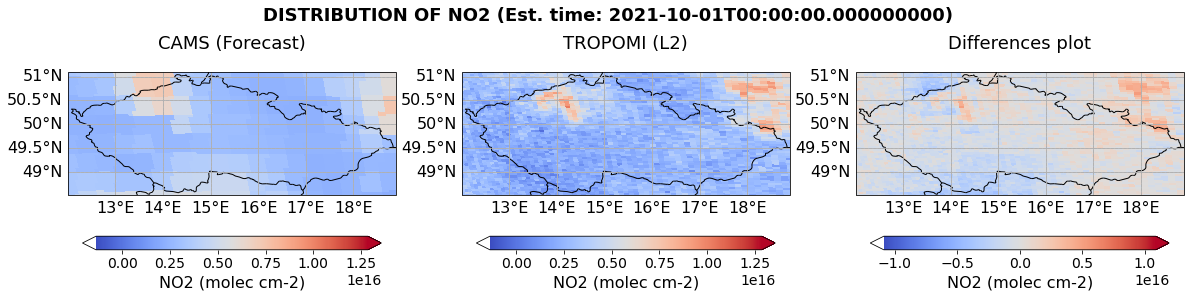

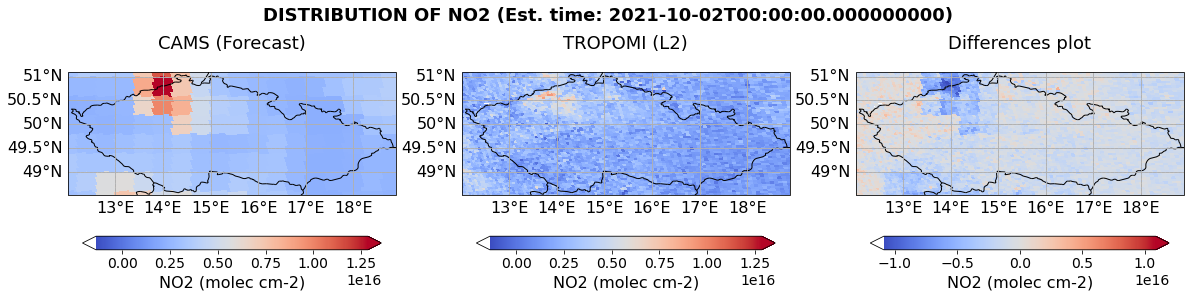

In [20]:
# Choose distribution (aggregated, individual or animated)
distribution_type = 'individual'

# Choose range (original, equal or manual)
range_type = 'equal'
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'coolwarm' 

visualize_model_vs_sensor(model, sensor, component_nom, units, merge_table, plot_dates, plot_bbox, 20, 0.80, 
                          model_type, sensor_type, range_type, distribution_type, projection,
                          color_scale, vmin_manual, vmax_manual)

### Compare CAMS original and averaged total columns

/home/alba/adc-toolbox/env-new/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


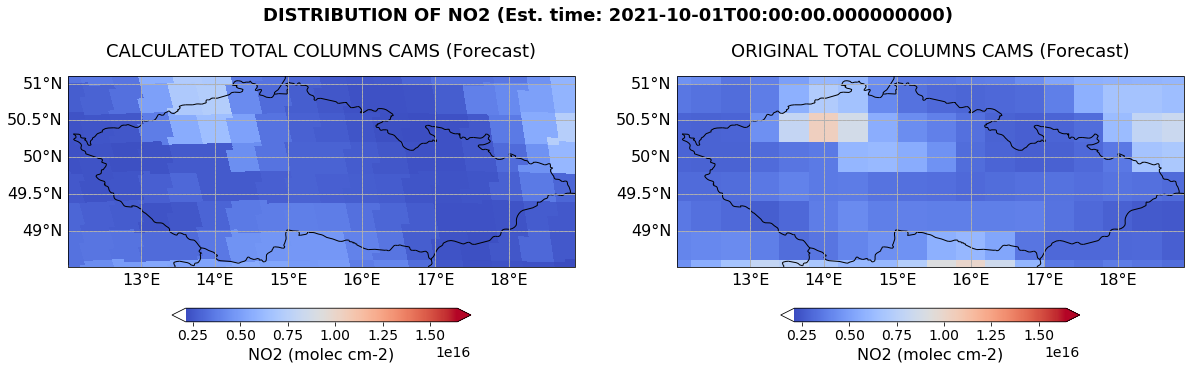

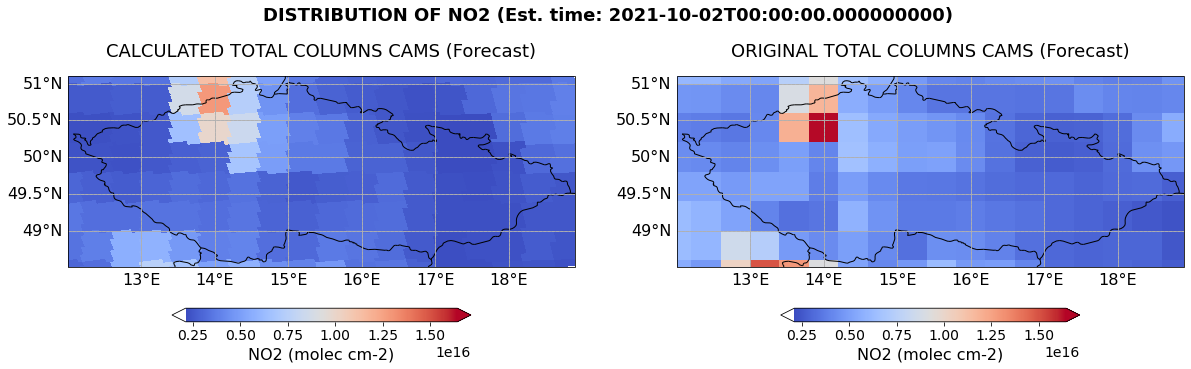

In [21]:
# Choose range (original, equal or manual)
range_type = 'equal' # original or equal
vmin_manual = None
vmax_manual = None

# Define projection and colors
projection = ccrs.PlateCarree()
color_scale = 'coolwarm' 

visualize_model_original_vs_calculated(model, component_nom,units, merge_table, model_total_ds, plot_dates, 
                                       plot_bbox, 20, 1, model_type, range_type, projection, color_scale,
                                       vmin_manual, vmax_manual)

## 7. Retrieve nearest values to specific latitude and longitude

In [22]:
coords_search_list = (50, 60,
                      4, 10,
                      20, 30)
retrieval_table_all =  retrieve_coords(merge_table.dropna(), coords_search_list, component_nom, 
                                       sensor, model, plot_dates, units)
retrieval_table_all

scanline  ground_pixel  \
lat_search lon_search latitude  longitude time                                 
50         60         48.490887 19.164270 2021-10-01     154.0         418.0   
                      48.560028 19.416794 2021-10-02     225.0         381.0   
4          10         48.413593 12.088854 2021-10-01     154.0         350.0   
                      47.998871 12.233796 2021-10-02     225.0         272.0   
20         30         48.490887 19.164270 2021-10-01     154.0         418.0   
                      48.560028 19.416794 2021-10-02     225.0         381.0   

                                                      model_column  \
lat_search lon_search latitude  longitude time                       
50         60         48.490887 19.164270 2021-10-01  2.112584e+15   
                      48.560028 19.416794 2021-10-02  2.332119e+15   
4          10         48.413593 12.088854 2021-10-01  3.380061e+15   
                      47.998871 12.233796 2021-10-02  3.261164e+15   
20         30         48.490887 19.164270 2021-10-01  2.112584e+15   
                      48.560028 19.416794 2021-10-02  2.332119e+15   

                                                      sensor_column  \
lat_search lon_search latitude  longitude time                        
50         60         48.490887 19.164270 2021-10-01   1.789018e+15   
                      48.560028 19.416794 2021-10-02   8.641931e+14   
4          10         48.413593 12.088854 2021-10-01   3.455946e+15   
                      47.998871 12.233796 2021-10-02   9.396234e+14   
20         30         48.490887 19.164270 2021-10-01   1.789018e+15   
                      48.560028 19.416794 2021-10-02   8.641931e+14   

                                                        difference  
lat_search lon_search latitude  longitude time                      
50         60         48.490887 19.164270 2021-10-01 -3.235658e+14  
                      48.560028 19.416794 2021-10-02 -1.467926e+15  
4          10         48.413593 12.088854 2021-10-01  7.588535e+13  
                      47.998871 12.233796 2021-10-02 -2.321540e+15  
20         30         48.490887 19.164270 2021-10-01 -3.235658e+14  
                      48.560028 19.416794 2021-10-02 -1.467926e+15

## 8. Scatter plots by bbox

Fit equation: NO2_model = NO2_sensor * 0.52 + (2.20E+15)
Coefficient of determination (R2): 0.16


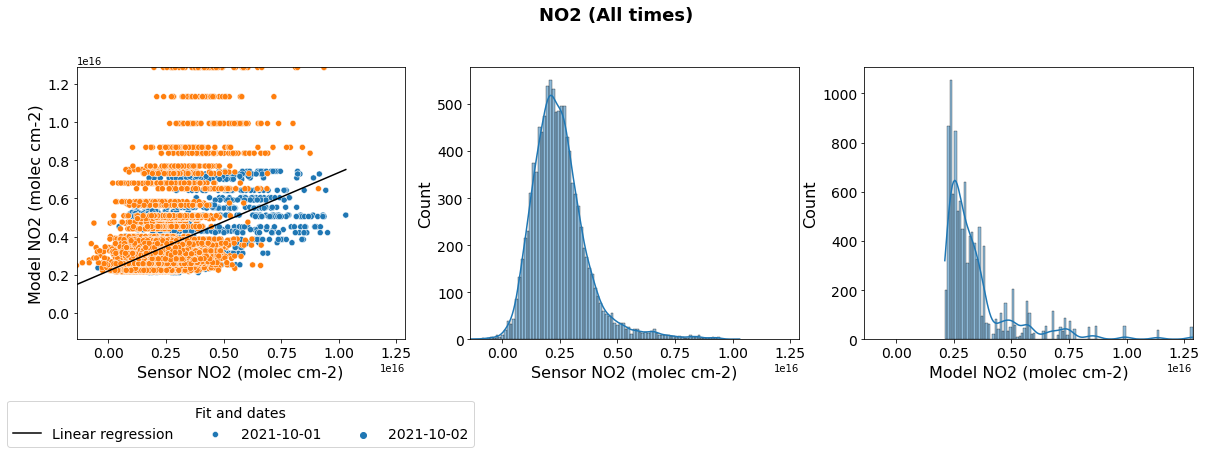

In [23]:
show_seasons = False
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [24]:
summary

,Period,Location,Score,Coefficient,Intercept
0,"[2021-10-01T00:00:00.000000000, 2021-10-02T00:...","((12, 48.5), (18.9, 51.1))",0.159383,0.515896,2.196614e+15


## 9. Scatter plots by season

Fit equation: NO2_model = NO2_sensor * 0.52 + (2.20E+15)
Coefficient of determination (R2): 0.16


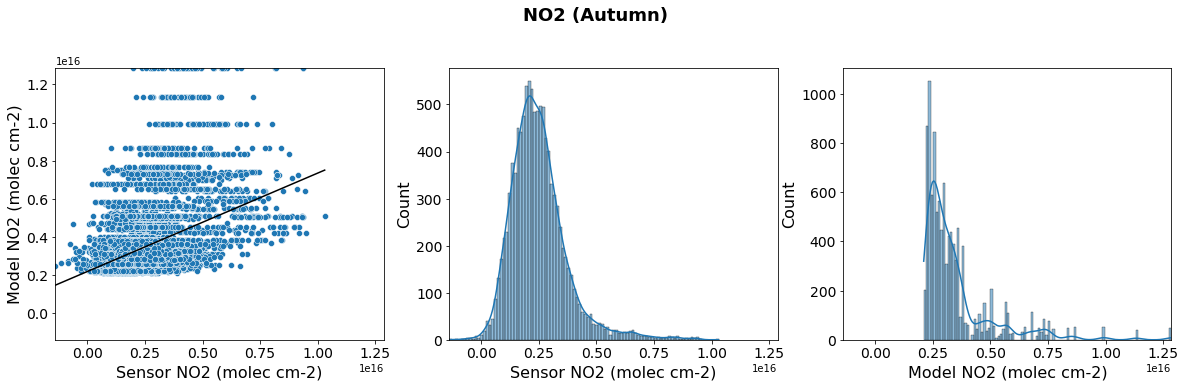

In [25]:
show_seasons = True
extent_definition = 'bbox' # bbox or country
scatter_plot_type = 'individual' # aggregated or individual

lim_min = None
lim_max = None

summary = scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
                       extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_bbox)

In [26]:
summary

,Period,Location,Score,Coefficient,Intercept
0,Autumn,"((12, 48.5), (18.9, 51.1))",0.159383,0.515896,2.196614e+15


## 10. Scatter plots by country (Google API required!)

In [27]:
"""
show_seasons = False
extent_definition = 'country' # bbox or country
scatter_plot_type = 'aggregated' # aggregated or individual
plot_countries = ['Czech Republic', 'Poland', 'Germany']

lim_min = None
lim_max = None

scatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, 
             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)
"""

"\nshow_seasons = False\nextent_definition = 'country' # bbox or country\nscatter_plot_type = 'aggregated' # aggregated or individual\nplot_countries = ['Czech Republic', 'Poland', 'Germany']\n\nlim_min = None\nlim_max = None\n\nscatter_plot(merge_table.dropna(), component_nom, units, sensor, plot_dates, 1.05, \n             extent_definition, show_seasons, scatter_plot_type, lim_min, lim_max, plot_countries)\n"

In [28]:
#summary